In [2]:
import torch
import torch.tensor
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
%config Completer.use_jedi = False
%matplotlib inline
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
def random_normal_samples(n, dim=2):
    return torch.zeros(n, dim).normal_(mean=0, std=1)

In [4]:
def w_1(z):
    return np.sin((2 * np.pi * z[0]) / 4)

def w_2(z):
    return 3 * np.exp(-.5 * ((z[0] - 1) / .6) ** 2)

def sigma(x):
    return 1 / (1 + np.exp(- x))

def w_3(z):
    return 3 * sigma((z[0] - 1) / .3) 

def pot_1(z):
    outer_term_1 = .5 * ( (z.norm() - 2) / .4 ) ** 2
    inner_term_1 = torch.exp( (-.5 * ((z[1] - 2) / .6) ** 2) )
    inner_term_2 = torch.exp( (-.5 * ((z[1] + 2) / .6 ) ** 2) )
    outer_term_2 = torch.log(inner_term_1 + inner_term_2 + 1e-7)
    return outer_term_1 - outer_term_2

def pot_2(z):
    return .5 * ((z[1] - w_1(z) / .4 )) ** 2


def pot_3(z):
    term_1 = torch.exp(-.5 * ((z[1] - w_1(z[0], z[1])) / .35) **2) 
    term_2 = np.exp(-.5 * ((z[1] - w_1(z) + w_2(z)) / .35) ** 2)
    return -np.log(term_1 + term_2)


def pot_4(z):
    term_1 = torch.exp(-.5 * ((z[1] - w_1(z)) / .4) **2) 
    term_2 = torch.exp(-.5 * ((z[1] - w_1(z) + w_3(z)) / .35) ** 2)
    return -torch.log(term_1 + term_2)



In [63]:
class VariationalApproximation(nn.Module):
    def __init__(self, D, n_flows=2):
        super(VariationalApproximation, self).__init__()
        self.flows = nn.ModuleList(
            [planar_flow(D) for _ in range(n_flows)])
        

    def sample(self, dim):
        sample = random_normal_samples(dim)
        for flow in self.flows:
            sample = flow(sample)
        return sample
     
    def log_p(self, x, potential_function=pot_1):
        base_logp = torch.sum(-potential_function(x))

        logp_accum = 0
        prev_sample = x
        for i in range(len(self.flows)):
            logp_accum += torch.sum(self.flows[i].log_prob(prev_sample))
            prev_sample = self.flows[i](prev_sample)

        return base_logp - logp_accum

In [140]:
class planar_flow(nn.Module):
    def __init__(self, D):
        super(planar_flow, self).__init__()
        self.u = nn.Linear(D, D)
        self.w = nn.Linear(D, D)
        
        self.b = nn.Parameter(torch.rand(1, D))
        self.h = torch.tanh
    
    def forward(self, z):
        linear_term = self.w(z) + self.b
        return z + self.u(self.h(linear_term))

    def psi(self, z):
        inner = (self.w(z) + self.b)
        return self.w(1 - (self.h(inner) ** 2))

    def log_prob(self, z):
        inner = 1 + self.u(self.psi(z))
        return torch.log(torch.abs(inner) + 1e-10)
        

In [ ]:
model = VariationalApproximation(2, 10)
opt = torch.optim.Adam(params = model.parameters(), lr=1e-4)
losses = []


In [202]:
for i in range(10000):
    if i % 500  == 0:
        print("Iteration {}".format(i))
    samples = Variable(random_normal_samples(10000))
    opt.zero_grad()
    loss = - model.log_p(samples, pot_1)
    loss.backward()
    losses.append(loss.item())
    opt.step()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


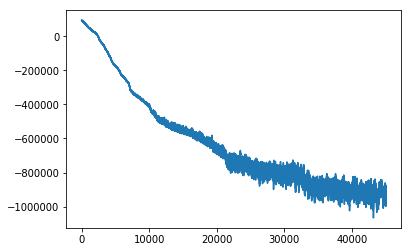

In [200]:
# Look at the learning
plt.plot(losses)

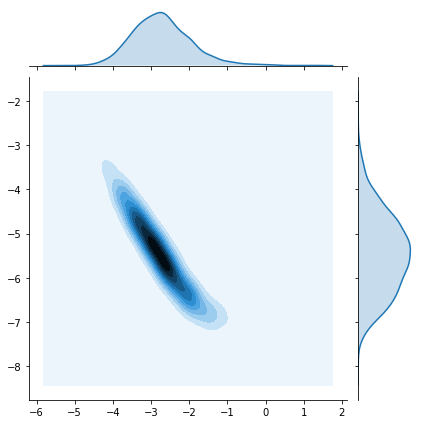

In [201]:
samples = (model.sample(2000)).detach().numpy()
sns.jointplot(samples[:, 0], samples[:, 1], kind='kde')